# MOVIE STUDIO ANALYSIS 

<img src="images/moviedog.jpg" style="width:100%; height:auto;">

## Overview 

Our company has decided to create a new movie studio, but they don’t know anything about creating movies. We have been charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.Our focus will be to make suggestions for the type of movies that will be the most profitable for our new movie division.

We will be using the following datasets

1. `rt.reviews.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
2. `rt.movie_info.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
2. `im.db` from [IMDB](https://www.imdb.com/)
3. `tn.movie_budgets.csv` from [The Numbers](https://www.the-numbers.com/)

In [1]:
# Import libraries

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats

%matplotlib inline

# Suppress harmless warnings for use_inf_as_na
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
# Loading reviews Dataset

# reviews Dataset
file_path = 'data/rt.reviews.tsv'

try:
    review_df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f"Error parsing file: {e}")

review_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [3]:
# loading imdb database
conn = sqlite3.connect('data/im.db') 

q_movie_basics = """SELECT * 
FROM movie_basics
      JOIN movie_ratings 
      ON movie_basics.movie_id = movie_ratings.movie_id;
      """
movie_basics_df = pd.read_sql(q_movie_basics, conn)

movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119


In [4]:
# Loading Box Office Mojo Dataset 
path = 'data/bom.movie_gross.csv'
movie_gross_df = pd.read_csv(path)

In [5]:
# Loading movie info dataset to dataframe
path = 'data/rt.movie_info.tsv'
movie_info_df = pd.read_csv(path, sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [6]:
# Loading 'The Numbers' Dataset
path = 'data/tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)
movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## Cleaning the dataset

1. review_df

In [7]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [8]:
# checking null values in dataset
review_df.isnull().sum()

# checking whether each column has an appropriate data type
review_df.dtypes

id             int64
review        object
rating        object
fresh         object
critic        object
top_critic     int64
publisher     object
date          object
dtype: object

## Cleaning review_df, movie_info_df 

### Merging review_df and movie_info_df

In [9]:
# Using the merge() function in pandas to merge the two datasets on a common column.

merged_df = pd.merge(review_df, movie_info_df, on='id', how='inner')

merged_df.head()

,id,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,rating_y,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


In [10]:
# Dropping the following columns: review, critic, top_critic, publisher, synopsis, currency, box_office
# writer, & studio columns from 'merged_df' dataframe

merged_df = merged_df.drop(['review', 'critic', 'top_critic', 'publisher', 'synopsis', 'writer', 'studio', 'currency', 'box_office'], axis=1)

merged_df.head()

,id,rating_x,fresh,date,rating_y,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes


In [11]:
# change column names from 'rating_x' to 'star_rating' and 'rating_y' to 'MPAA_rating'

merged_df.rename(columns={'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'}, inplace=True)
merged_df.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes


In [12]:
# checking null values in merged_df 
merged_df.isnull().sum()

id                  0
star_rating     13517
fresh               0
date                0
MPAA_rating        86
genre              87
director         5440
theater_date     1226
dvd_date         1226
runtime           838
dtype: int64

In [13]:
# create 'merged_df1' from 'merged_df' where 'star_rating' is not null

merged_df1 = merged_df[merged_df['star_rating'].notnull()]
merged_df1

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
6,3,C,rotten,"July 17, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
7,3,2/5,rotten,"April 21, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
11,3,B-,fresh,"February 3, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
12,3,2/4,rotten,"January 15, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
...,...,...,...,...,...,...,...,...,...,...
54424,2000,1.5/5,rotten,"September 26, 2002",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",94 minutes
54428,2000,1/5,rotten,"September 21, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",94 minutes
54429,2000,2/5,rotten,"July 17, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",94 minutes
54430,2000,2.5/5,rotten,"September 7, 2003",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",94 minutes


In [14]:
# check unique ratings in 'star_rating' column

merged_df1['star_rating'].unique()

array(['3/5', 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4', '6/10',
       '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-', '5/5',
       'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
       

In [15]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df1['standardized_rating'] = merged_df1['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
merged_df1.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime,standardized_rating
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes,6.0
6,3,C,rotten,"July 17, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes,6.5
7,3,2/5,rotten,"April 21, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes,4.0
11,3,B-,fresh,"February 3, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes,7.5
12,3,2/4,rotten,"January 15, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes,5.0


In [16]:
# find the mean of new column 'standardized_rating'
print(merged_df1['standardized_rating'].mean())

6.39170781792402


In [17]:
# fill standardized_rating with mean
merged_df1['standardized_rating'].fillna(merged_df1['standardized_rating'].mean(), inplace=True)
print(merged_df1['standardized_rating'].mean())

6.39170781792402


In [18]:
# check null values in 'standardized rating' 
merged_df1['standardized_rating'].isnull().sum()

0

In [19]:
merged_df1.isnull().sum()

id                        0
star_rating               0
fresh                     0
date                      0
MPAA_rating              75
genre                    76
director               4215
theater_date            900
dvd_date                900
runtime                 618
standardized_rating       0
dtype: int64

In [20]:
# drop the rows with missing values in 'genre' and 'MPAA_rating'
merged_df1.dropna(subset=['genre', 'MPAA_rating'], inplace=True)

In [21]:
# drop 'star_rating' column because we have 'standardized_rating'
merged_df1.drop('star_rating', axis=1, inplace=True)

In [22]:
# check and drop duplicates in merged_df1
merged_df1.drop_duplicates(inplace=True)

merged_df1.duplicated().sum()

0

In [23]:
# Drop missing values for'theater_data', 'dvd_date' in 'merged_df1' 
merged_df1 = merged_df1.dropna(subset=['theater_date', 'dvd_date'])

# Fill missing values in 'director' with 'Unknown'
merged_df1['director'] = merged_df1['director'].fillna('Unknown')

In [24]:
# Impute missing values in 'runtime' with the mean value

# Extract integer values from 'runtime' column using regular expression
merged_df1['runtime'] = merged_df1['runtime'].str.extract('(\d+)').astype(float)

# Calculate the mean of the numeric values in 'runtime' column
mean_runtime = merged_df1['runtime'].mean()

# Fill missing values in 'runtime' column with the mean value
merged_df1['runtime'].fillna(mean_runtime, inplace=True)

In [25]:
# list null values in 'runtime' column 
merged_df1['runtime'].isnull().sum()

0

## Cleaning movie_budgets_df

In [26]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [27]:
# check null values in movie_budgets_df
movie_budgets_df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

I checked for null values in `movie_budget_df`. There are none. 

In [28]:
# Check for duplicates in movie_budgets_df
movie_budgets_df.duplicated().sum()

0

### Standardizing Datetime and removing dollar signs

In [29]:
# Convert 'release_date' to datetime
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Function to remove dollar signs and commas and convert to numeric
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

# Apply the function to the budget and gross columns
movie_budgets_df['production_budget'] = clean_currency(movie_budgets_df['production_budget'])
movie_budgets_df['domestic_gross'] = clean_currency(movie_budgets_df['domestic_gross'])
movie_budgets_df['worldwide_gross'] = clean_currency(movie_budgets_df['worldwide_gross'])

movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


I checked for duplicates in `movie_budget_df`. There are none.

## Cleaning movie_basics_df

In [30]:
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73856 non-null  object 
 7   averagerating    73856 non-null  float64
 8   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


In [31]:
# checking for duplicates in movie_basics_df
movie_basics_df.duplicated().sum()

0

In [32]:
# checking for null values in movie_basics_df
movie_basics_df.isnull().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
movie_id              0
averagerating         0
numvotes              0
dtype: int64

In [33]:
# drop null values on 'runtime_minutes' and 'genres' columns
movie_basics_df.dropna(subset=['runtime_minutes', 'genres'], inplace=True)

## Visualization 

1. Univariate Analysis 

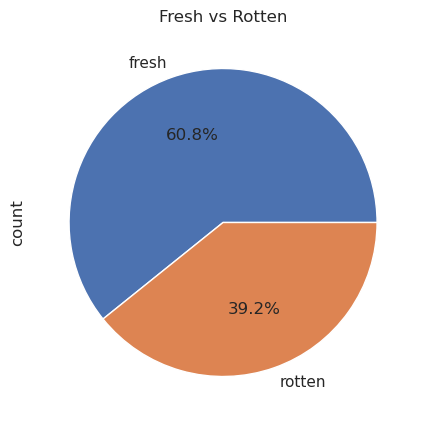

In [34]:
# create a pie chart of 'fresh' vs 'rotten' in merged_df1
plt.figure(figsize=(8,5))
merged_df1['fresh'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Fresh vs Rotten')
plt.show()

/tmp/ipykernel_63692/3615550490.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(movie_budgets_df['production_budget'], kde=False)


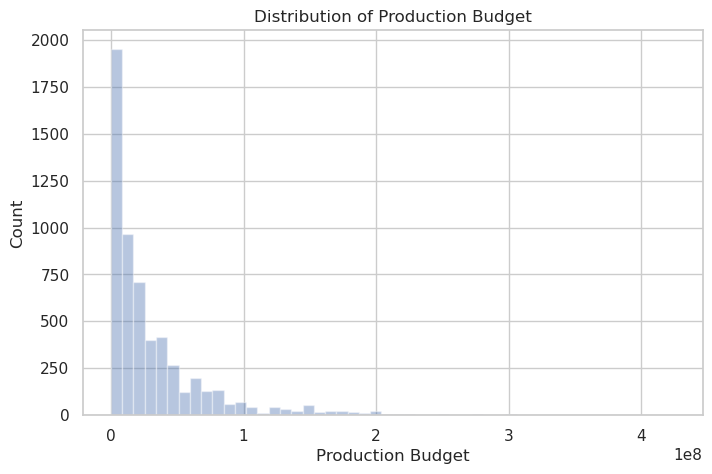

In [35]:
# plot a distplot of 'production_budget' in movie_budgets_df
plt.figure(figsize=(8,5))
sns.distplot(movie_budgets_df['production_budget'], kde=False)
plt.title('Distribution of Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('Count')
plt.show()

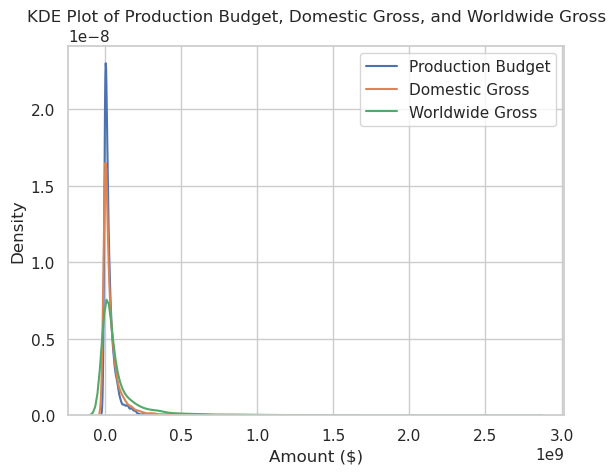

In [36]:
# kde plot of 'production_budget', 'domestic_gross', 'worldwide_gross'
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the KDE for each column
sns.kdeplot(data=movie_budgets_df, x='production_budget', ax=ax, label='Production Budget')
sns.kdeplot(data=movie_budgets_df, x='domestic_gross', ax=ax, label='Domestic Gross')
sns.kdeplot(data=movie_budgets_df, x='worldwide_gross', ax=ax, label='Worldwide Gross')

# Set the title and labels
ax.set_title('KDE Plot of Production Budget, Domestic Gross, and Worldwide Gross')
ax.set_xlabel('Amount ($)')
ax.set_ylabel('Density')

# Show the legend
ax.legend()

# Show the plot
plt.show()

### IMDB Dataset Analysis

In [37]:
# checking genre unique values
movie_basics_df['genres'].unique()

array(['Action,Crime,Drama', 'Biography,Drama', 'Drama',
       'Comedy,Drama,Fantasy', 'Adventure,Animation,Comedy', 'History',
       'Documentary', 'Animation,Drama,History', 'Drama,Mystery',
       'Action,Animation,Comedy', 'Biography,Comedy,Drama',
       'Action,Drama', 'Documentary,History', 'Sci-Fi', 'Comedy',
       'Thriller', 'Adventure,Animation,Sci-Fi', 'Drama,Horror',
       'Drama,Mystery,Thriller', 'Drama,Family',
       'Adventure,Comedy,Romance', 'Comedy,Drama',
       'Adventure,Drama,Romance', 'Biography', 'Horror',
       'Adventure,Comedy,Drama', 'Drama,Sci-Fi,Thriller', 'Action',
       'Comedy,Drama,Romance', 'Action,Adventure,Sci-Fi', 'Crime,Drama',
       'Comedy,Family', 'Adventure', 'Drama,History,War',
       'Action,Thriller', 'Comedy,Crime', 'Crime,Drama,Thriller',
       'Action,Sci-Fi,Thriller', 'Fantasy', 'Drama,Mystery,Sci-Fi',
       'Biography,Drama,History', 'Action,Comedy,Crime',
       'Action,Adventure,Thriller', 'Horror,Mystery,Thriller',
    

In [38]:
# Normalize genre strings
movie_basics_df['genres'] = movie_basics_df['genres'].str.strip().str.lower()

# Tokenize genres
movie_basics_df['genres_list'] = movie_basics_df['genres'].str.split(',')

# Expand genres into separate columns for one-hot encoding
genres_expanded = movie_basics_df['genres_list'].explode().unique()
for genre in genres_expanded:
    movie_basics_df[genre] = movie_basics_df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Drop the intermediate columns
imdb_df = movie_basics_df.drop(columns=['genres', 'genres_list'])

imdb_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,movie_id,averagerating,numvotes,action,crime,...,war,music,sport,western,musical,news,reality-tv,game-show,adult,short
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,tt0063540,7.0,77,1,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,tt0066787,7.2,43,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,tt0069049,6.9,4517,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,tt0100275,6.5,119,0,0,...,0,0,0,0,0,0,0,0,0,0
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,tt0137204,8.1,263,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plot for Genre Frequency Distribution

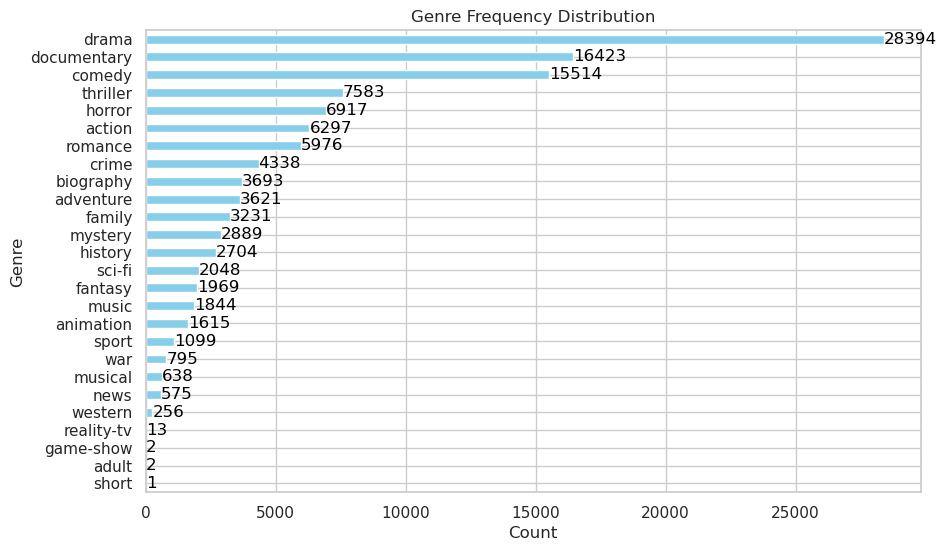

In [39]:
# Count the frequency of each genre
genre_counts = imdb_df[genres_expanded].sum()

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = genre_counts.sort_values().plot(kind='barh', color='skyblue')

# Add count labels next to each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, p.get_y() + p.get_height() / 2, int(width), 
            ha='left', va='center', color='black')

plt.title('Genre Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

### Genre combinations co-occurrence - Heatmap

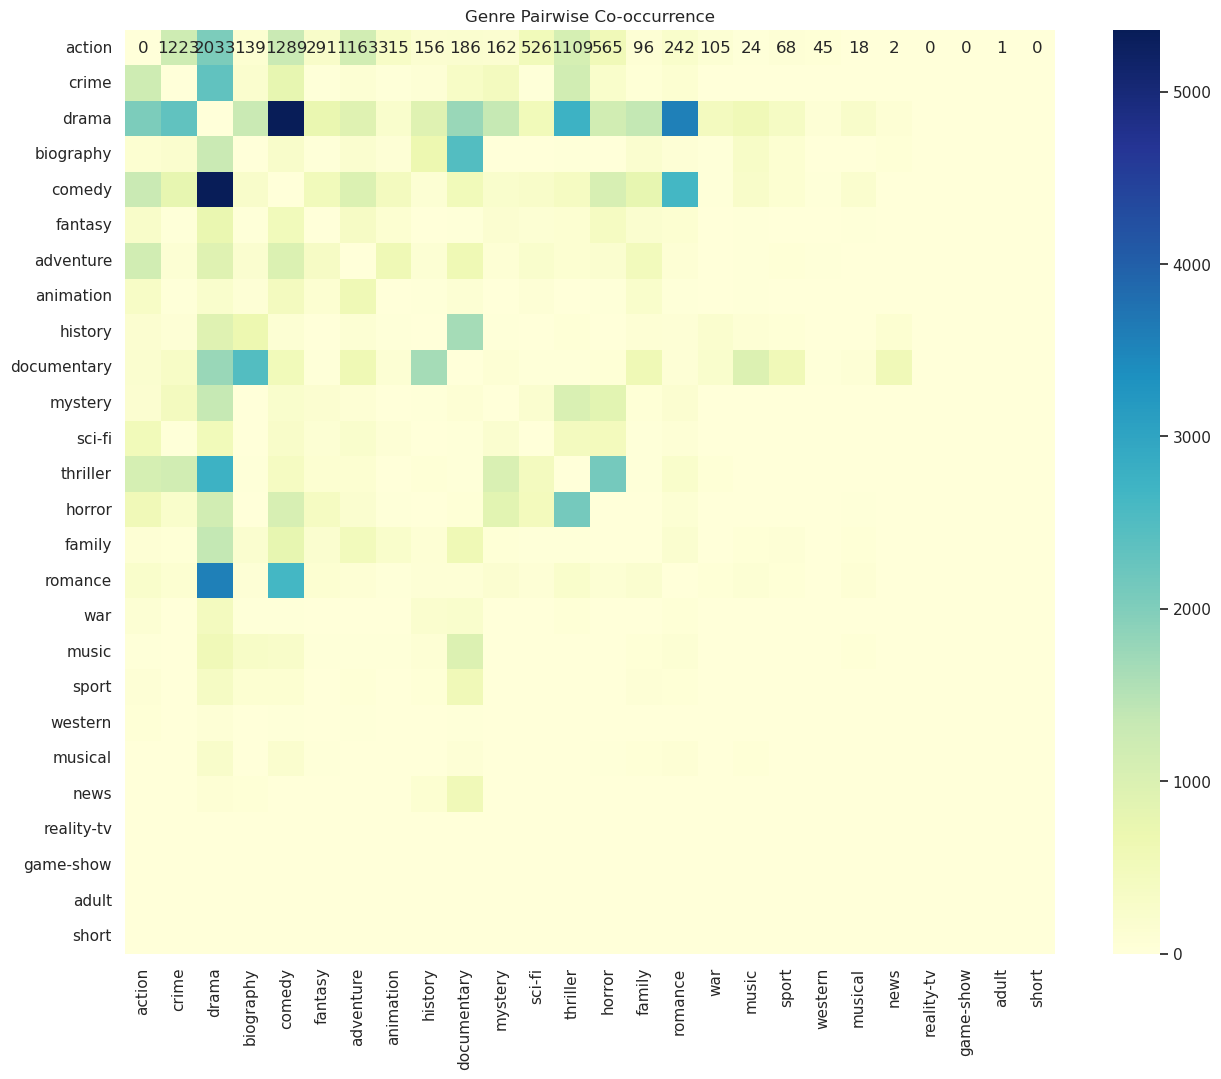

In [40]:
# Create a DataFrame for pairwise genre combinations
from itertools import combinations

# Calculate pairwise genre co-occurrence
genre_pairs = pd.DataFrame(
    index=genres_expanded,
    columns=genres_expanded,
    data=0
)

for genre1, genre2 in combinations(genres_expanded, 2):
    genre_pairs.loc[genre1, genre2] = ((imdb_df[genre1] & imdb_df[genre2]).sum())
    genre_pairs.loc[genre2, genre1] = genre_pairs.loc[genre1, genre2]

# Plot the pairwise co-occurrence
plt.figure(figsize=(15, 12))
sns.heatmap(genre_pairs, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre Pairwise Co-occurrence')
plt.show()

### Genre combinations co-occurrence - Table

In [41]:
# Normalize genre strings
movie_basics_df['genres'] = movie_basics_df['genres'].str.strip().str.lower()

# Tokenize genres
movie_basics_df['genres_list'] = movie_basics_df['genres'].str.split(',')

# Create a DataFrame to store genre combinations
genre_combinations = pd.DataFrame(columns=['Combination', 'Count'])

# Generate genre combinations for each movie and count occurrences
combination_counts = {}

for _, row in movie_basics_df.iterrows():
    genres = sorted(row['genres_list'])  # Sort genres to ensure order consistency
    for r in range(1, len(genres) + 1):
        for combo in combinations(genres, r):
            combo_str = ' & '.join(combo)
            if combo_str in combination_counts:
                combination_counts[combo_str] += 1
            else:
                combination_counts[combo_str] = 1

# Convert the combination counts dictionary to a DataFrame
genre_combinations = pd.DataFrame(list(combination_counts.items()), columns=['Combination', 'Count'])

# Sort by Count in descending order
result_table = genre_combinations.sort_values(by='Count', ascending=False)

# Print the sorted table
print("Genre Combination Counts:")
print(result_table)

Genre Combination Counts:
                          Combination  Count
2                               drama  28394
22                        documentary  16423
9                              comedy  15514
36                           thriller   7583
40                             horror   6917
..                                ...    ...
798             drama & war & western      1
800        adventure & music & sci-fi      1
802        biography & family & sport      1
804  action & animation & documentary      1
966     documentary & family & sci-fi      1

[967 rows x 2 columns]


### Plot for Top 20 Genre Combinations by Count

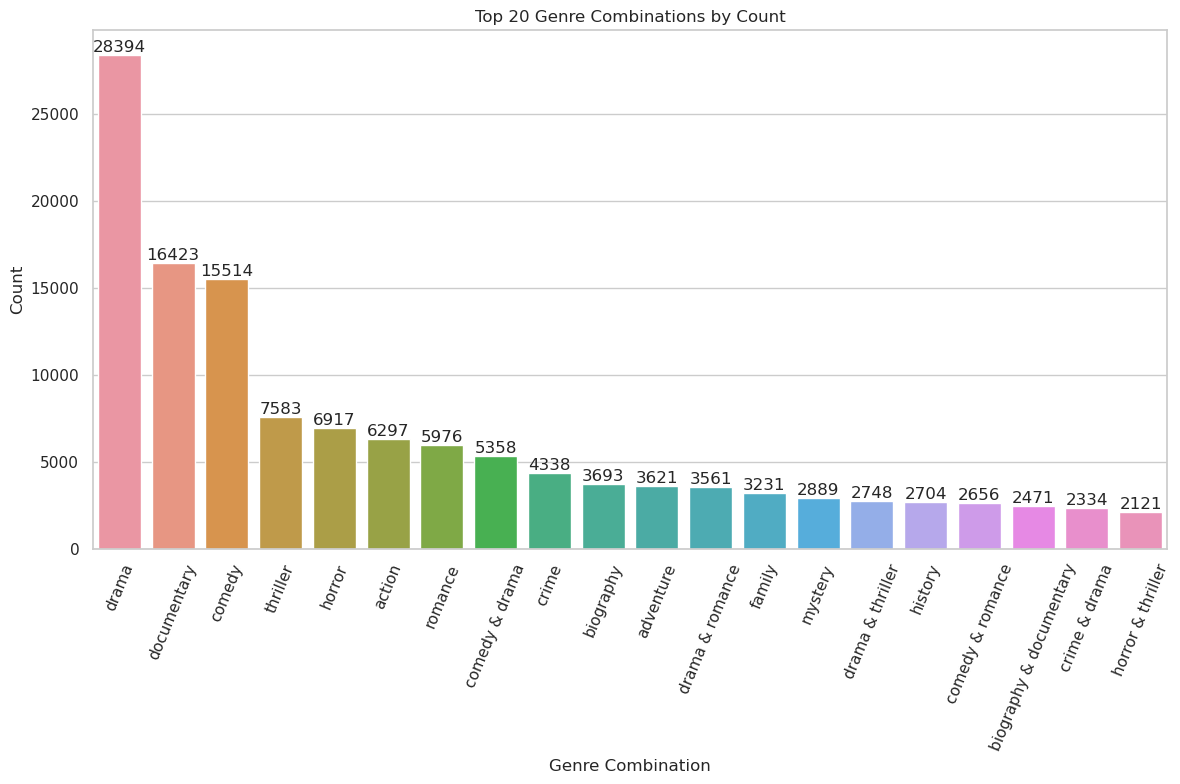

In [42]:
# Create DataFrame and select top 20 rows
result = pd.DataFrame(result_table)
result = result.head(20)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=result['Combination'], y=result['Count'])

# Adding annotations (count values) on top of each bar
for index, value in enumerate(result['Count']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=67.5)
plt.title('Top 20 Genre Combinations by Count')
plt.xlabel('Genre Combination')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Movie Budgets Dataset Analysis 

In [43]:
movie_budgets_df.describe()

,id,release_date,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,2004-07-06 05:20:31.546177792,3.158776e+07,4.187333e+07,9.148746e+07
min,1.000000,1915-02-08 00:00:00,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,2000-04-22 18:00:00,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,2007-03-02 00:00:00,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,2012-12-25 00:00:00,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,2020-12-31 00:00:00,4.250000e+08,9.366622e+08,2.776345e+09
std,28.821076,NaN,4.181208e+07,6.824060e+07,1.747200e+08


In [44]:
movie_budgets_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr()

,production_budget,domestic_gross,worldwide_gross
production_budget,1.000000,0.685682,0.748306
domestic_gross,0.685682,1.000000,0.938853
worldwide_gross,0.748306,0.938853,1.000000


Correlation Analysis:

1. Production Budget vs Domestic Gross: 0.686
   - Moderately strong positive correlation
   - Higher budgets tend to yield higher domestic earnings

2. Production Budget vs Worldwide Gross: 0.748
   - Stronger positive correlation than domestic
   - Big budgets have more impact on global earnings

3. Domestic Gross vs Worldwide Gross: 0.939
   - Very strong positive correlation
   - Domestic success strongly indicates global success

Key Insights from this analysis:

1. Budget Impact: Higher budgets are associated with higher earnings, both domestically and worldwide. The stronger correlation with worldwide gross suggests that big-budget movies might have more international appeal or marketing reach.
2. Domestic performance is a good predictor of global performance. Domestic-Worldwide relationship: The very strong correlation between domestic and worldwide gross implies that domestic performance is a good indicator of global performance. This could be due to factors like marketing strategies that work well across markets or the global influence of the US film market.
3. Budget isn't the only factor; While there's a positive correlation between budget and earnings, it's not perfect. This suggests that other factors (like quality, marketing, timing, etc.) play significant roles in a movie's financial success.
4. Worldwide potential: The stronger correlation between budget and worldwide gross (compared to domestic gross) might indicate that higher budgets are particularly beneficial for international appeal, perhaps due to more spectacular visual effects, bigger stars, or larger marketing campaigns that resonate globally.

##### Top Movies by Worldwide Gross

In [45]:
top_grossing = movie_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)
top_grossing[['movie', 'worldwide_gross']]

,movie,worldwide_gross
0,Avatar,2.776345e+09
42,Titanic,2.208208e+09
5,Star Wars Ep. VII: The Force Awakens,2.053311e+09
6,Avengers: Infinity War,2.048134e+09
33,Jurassic World,1.648855e+09
66,Furious 7,1.518723e+09
26,The Avengers,1.517936e+09
3,Avengers: Age of Ultron,1.403014e+09
41,Black Panther,1.348258e+09
260,Harry Potter and the Deathly Hallows: Part II,1.341693e+09


##### Top Movies by ROI

In [46]:
movie_budgets_df['ROI'] = (movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']) / movie_budgets_df['production_budget']
top_roi = movie_budgets_df.sort_values('ROI', ascending=False).head(10)
top_roi[['movie', 'ROI']]

,movie,ROI
5745,Deep Throat,1799.000000
5613,Mad Max,497.750000
5492,Paranormal Activity,430.517853
5679,The Gallows,415.564740
5406,The Blair Witch Project,412.833333
5709,Super Size Me,341.058585
5346,Bambi,311.354312
5773,El Mariachi,290.704000
5676,Night of the Living Dead,262.921614
5210,Rocky,224.000000


In [47]:
# cleaning currency strings
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

# Clean and convert monetary columns to numeric
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency).astype(float)

In [48]:
# Average budget and gross by year

# Function to clean currency and handle potential errors
def clean_currency(x):
    if isinstance(x, str):
        try:
            return float(x.replace('$', '').replace(',', ''))
        except ValueError:
            return np.nan
    return x if pd.notnull(x) else np.nan

# Clean the monetary columns
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency)
    movie_budgets_df[col] = pd.to_numeric(movie_budgets_df[col], errors='coerce')

# Convert release_date to datetime and extract the year
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year

# Calculate yearly averages
yearly_avg = movie_budgets_df.groupby('year')[columns_to_clean].mean()
print(yearly_avg)

      production_budget  domestic_gross  worldwide_gross
year                                                    
1915       1.100000e+05    1.000000e+07     1.100000e+07
1916       2.929535e+05    4.000000e+06     4.000000e+06
1920       1.000000e+05    3.000000e+06     3.000000e+06
1925       2.072500e+06    1.000000e+07     1.550000e+07
1927       2.000000e+06    0.000000e+00     0.000000e+00
...                 ...             ...              ...
2016       4.097370e+07    5.042387e+07     1.313614e+08
2017       5.003073e+07    6.222259e+07     1.692240e+08
2018       4.813886e+07    7.378870e+07     1.824786e+08
2019       5.273896e+07    4.280029e+07     9.965411e+07
2020       9.400000e+07    0.000000e+00     0.000000e+00

[96 rows x 3 columns]


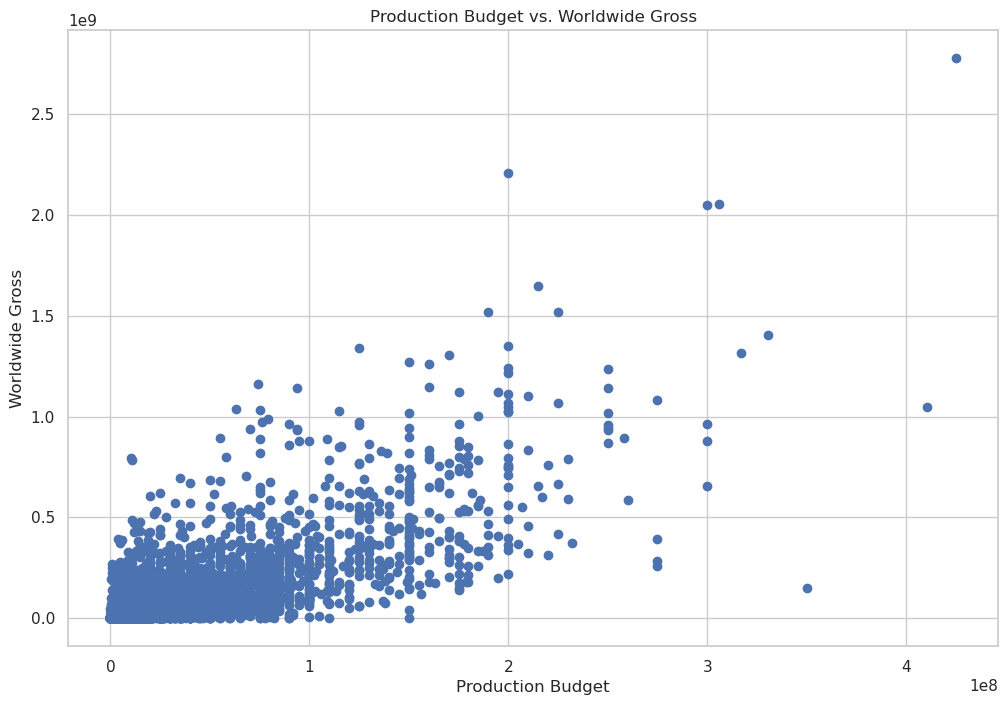

In [49]:
# visualize the relationship between budget and revenue
plt.figure(figsize=(12, 8))
plt.scatter(movie_budgets_df['production_budget'], movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()

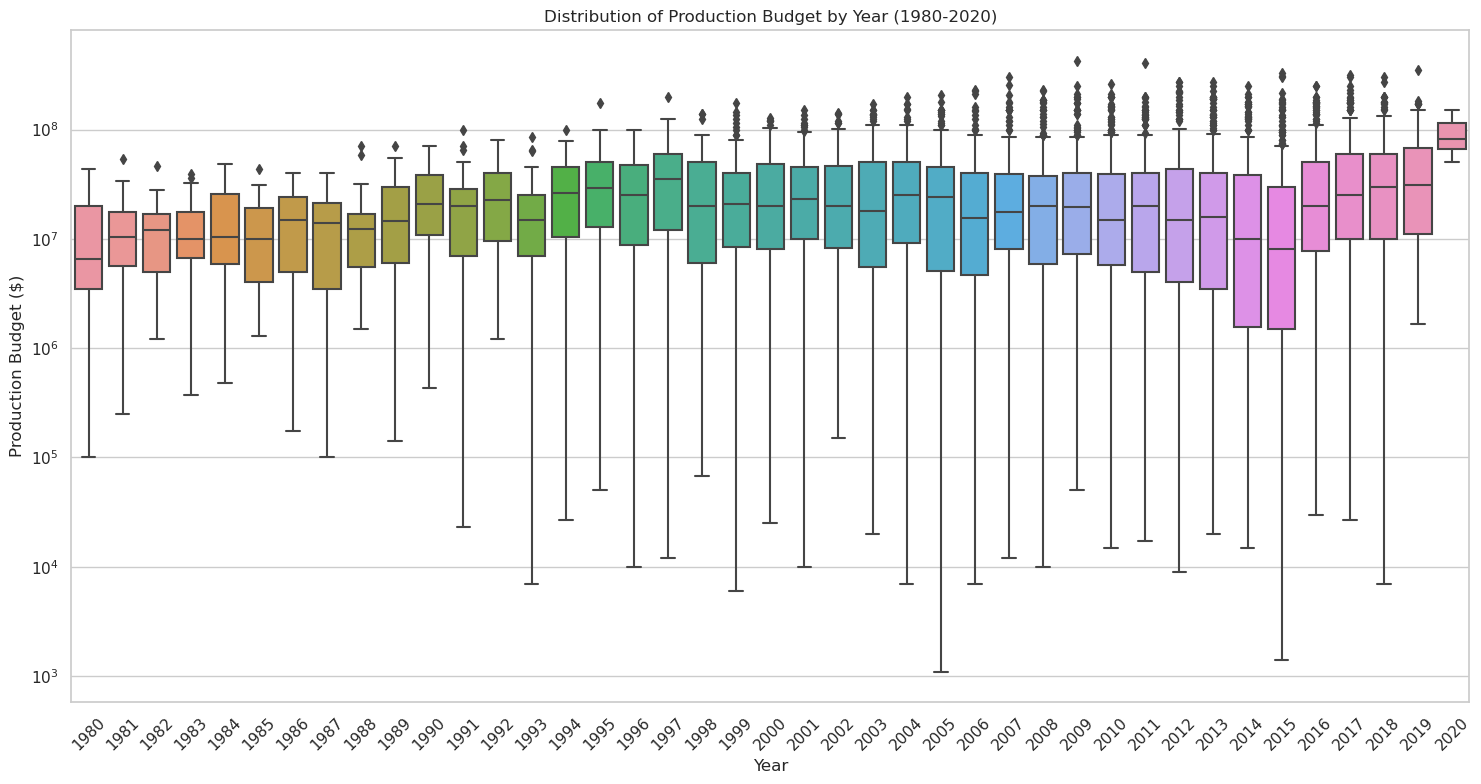

In [50]:
# Ensure the year and production_budget are in the correct format
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year
movie_budgets_df['production_budget'] = pd.to_numeric(movie_budgets_df['production_budget'], errors='coerce')

# Filter the dataframe for years 1980-2020
filtered_df = movie_budgets_df[(movie_budgets_df['year'] >= 1980) & (movie_budgets_df['year'] <= 2020)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='production_budget', data=filtered_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Production Budget ($)')
plt.title('Distribution of Production Budget by Year (1980-2020)')

# Use log scale for y-axis due to wide range of budget values
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

##### Distribution of Production Budget by Year

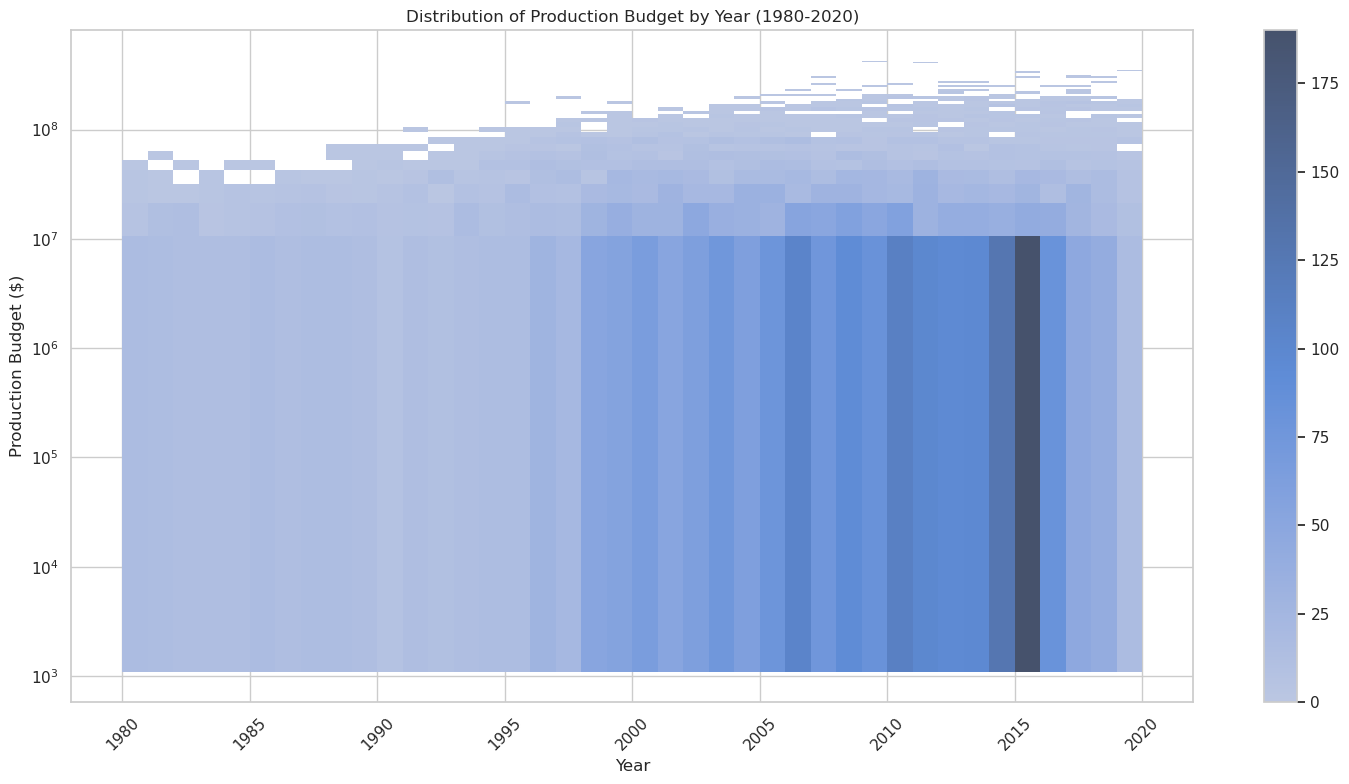

In [51]:
# Ensure the year and production_budget are in the correct format
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year
movie_budgets_df['production_budget'] = pd.to_numeric(movie_budgets_df['production_budget'], errors='coerce')

# Filter the dataframe for years 1980-2020
filtered_df = movie_budgets_df[(movie_budgets_df['year'] >= 1980) & (movie_budgets_df['year'] <= 2020)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.histplot(data=filtered_df, x='year', y='production_budget', bins=40, cbar=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Production Budget ($)')
plt.title('Distribution of Production Budget by Year (1980-2020)')

# Use log scale for y-axis due to wide range of budget values
plt.yscale('log')

# Adjust x-axis ticks
plt.xticks(range(1980, 2021, 5), rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

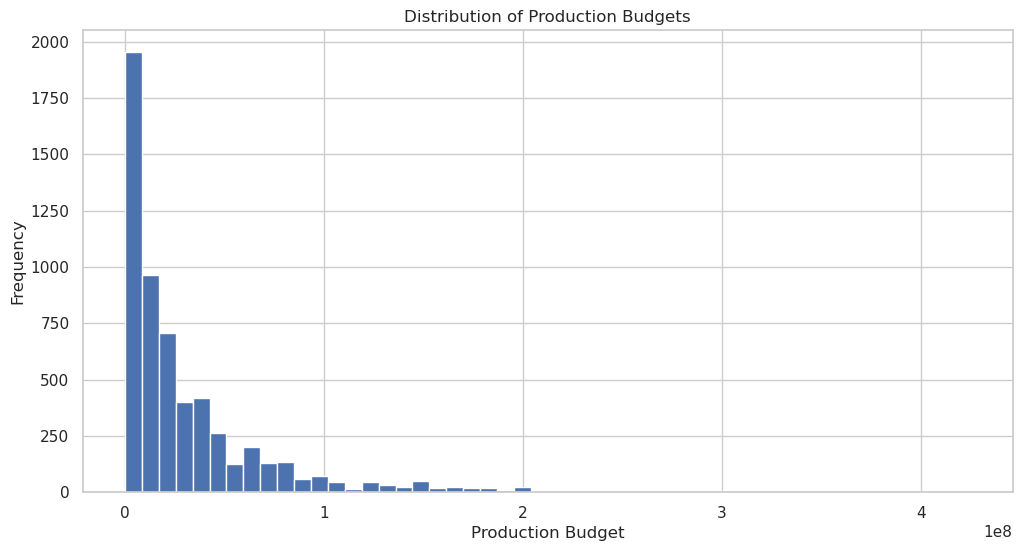

In [52]:
# distribution of production budget
plt.figure(figsize=(12, 6))
movie_budgets_df['production_budget'].hist(bins=50)
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.title('Distribution of Production Budgets')
plt.show()

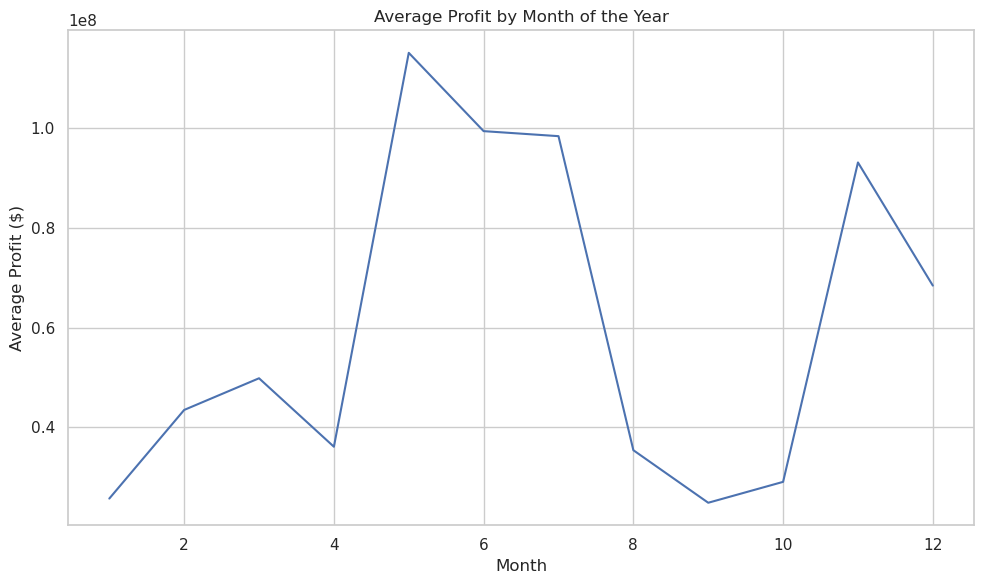

In [53]:
# Extract the month from the release_date column
movie_budgets_df['month'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.month

# Calculate the profit for each movie
movie_budgets_df['profit'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']

# Calculate the average profit by month
monthly_avg_profit = movie_budgets_df.groupby('month')['profit'].mean()

# Create the line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg_profit.index, y=monthly_avg_profit.values)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Profit by Month of the Year')

# Show the plot
plt.tight_layout()
plt.show()

### Merged_df1 Analysis

In [54]:
merged_df1.describe()

,id,runtime,standardized_rating
count,30809.000000,30809.000000,30809.000000
mean,1033.910578,109.967285,6.368065
std,582.620616,21.077938,2.172658
min,3.000000,52.000000,0.000000
25%,539.000000,96.000000,5.000000
50%,1069.000000,108.000000,6.250000
75%,1527.000000,119.000000,8.000000
max,2000.000000,358.000000,12.500000


In [55]:
merged_df1.head(2)

,id,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime,standardized_rating
0,3,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.0
6,3,rotten,"July 17, 2013",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.5


##### Correlation between Movie Runtime and Rating

In [56]:
# correlation between 'runtime' and 'standardized_rating' 
merged_df1[['runtime', 'standardized_rating']].corr()

,runtime,standardized_rating
runtime,1.000000,0.171451
standardized_rating,0.171451,1.000000



Correlation Analysis:

The correlation coefficient of 0.17 between movie runtime and critic rating is a weak positive correlation. This means that as movie runtime increases, there's a slight tendency for critic ratings to increase as well, but the relationship is not strong.

Key Insights from this analysis:

Limited impact: The low correlation suggests that runtime alone is not a major factor in determining critic ratings. Other factors likely play more significant roles in how critics rate movies.

Possible interpretations. Longer movies might slightly benefit from more time to develop characters and plot, potentially leading to marginally better ratings. However, the weak correlation also suggests that many short films receive high ratings, and many long films receive low ratings.

Not predictive. With such a weak correlation, runtime cannot be used reliably to predict critic ratings.

Complex relationship. The low correlation might indicate that the relationship between runtime and ratings is more complex and possibly non-linear.

Other factors: This result emphasizes the importance of other factors in determining a movie's critical reception, such as plot, acting, direction, etc.

In [57]:
# Count occurrences of each genre
genre_counts = merged_df1['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Calculate mean standardized rating for each genre
genre_ratings = merged_df1.groupby('genre')['standardized_rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'mean_standardized_rating']

# Merge genre counts and mean standardized ratings
genre_summary = pd.merge(genre_counts, genre_ratings, on='genre')

# Count occurrences of each MPAA rating
mpaa_counts = merged_df1['MPAA_rating'].value_counts().reset_index()
mpaa_counts.columns = ['MPAA_rating', 'count']

# Calculate average runtime for each MPAA rating
mpaa_runtime = merged_df1.groupby('MPAA_rating')['runtime'].mean().reset_index()
mpaa_runtime.columns = ['MPAA_rating', 'average_runtime']

# Merge MPAA counts and average runtimes
mpaa_summary = pd.merge(mpaa_counts, mpaa_runtime, on='MPAA_rating')

print("Genre Summary:")
print(genre_summary)
print("\nMPAA Rating Summary:")
print(mpaa_summary)

Genre Summary:
                                                 genre  count  \
0                                                Drama   4230   
1                                               Comedy   2483   
2                                         Comedy|Drama   2305   
3                           Drama|Mystery and Suspense   1702   
4                                 Comedy|Drama|Romance   1084   
..                                                 ...    ...   
231  Action and Adventure|Art House and Internation...      1   
232  Classics|Drama|Musical and Performing Arts|Mys...      1   
233  Art House and International|Drama|Mystery and ...      1   
234  Art House and International|Horror|Mystery and...      1   
235                                   Classics|Western      1   

     mean_standardized_rating  
0                    6.749614  
1                    5.323577  
2                    6.850047  
3                    6.493635  
4                    6.524585  
..          

In [58]:
# Group by director and calculate mean standardized rating and count of movies
director_stats = merged_df1.groupby('director').agg({
    'standardized_rating': 'mean',
    'id': 'count'  # Assuming 'id' is unique for each movie
}).rename(columns={'id': 'movie_count'})

# Sort by mean rating in descending order
director_stats_sorted = director_stats.sort_values('standardized_rating', ascending=False)

# Display the top directors
print(director_stats_sorted.head(20))

                       standardized_rating  movie_count
director                                               
Alain Tanner                     10.000000            1
Orson Welles                      9.348485           33
Alexander Mackendrick             9.201613           31
Ingmar Bergman                    9.189394           33
Yasujiro Ozu                      9.148148           27
Preston Sturges                   9.136364           11
Eric Rohmer                       9.125000            8
Cheryl Dunye                      9.000000            1
Dante Lam                         9.000000            1
Frank Capra                       8.750000           46
Blake Edwards                     8.750000            4
Jacques Tourneur                  8.750000            2
Joel Coen|Ethan Coen              8.731266          129
Anthony Mann                      8.708333            6
Sam Peckinpah                     8.677083           24
Marco Tullio Giordana             8.658537      

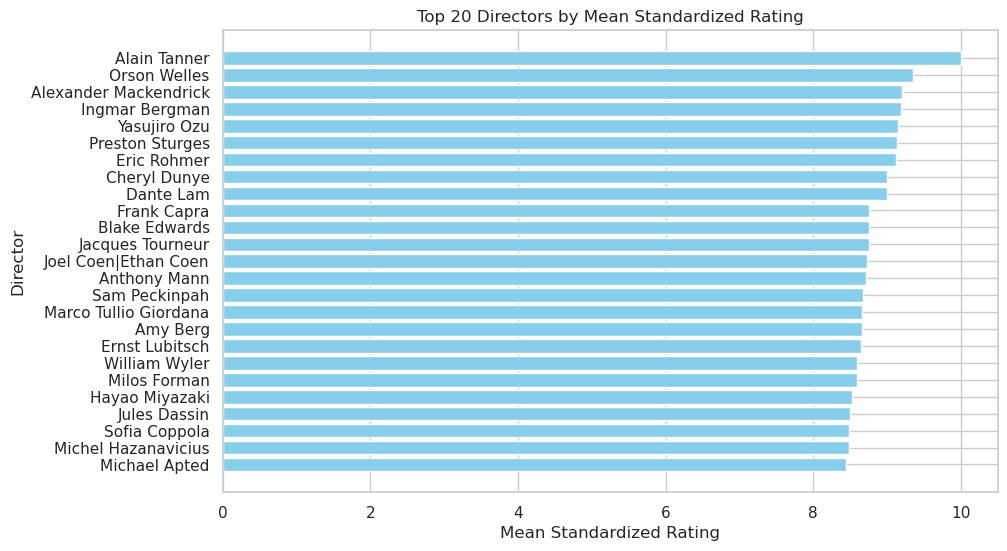

In [59]:
# Take the top 20 directors
top_directors = director_stats_sorted.head(25)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_directors.index, top_directors['standardized_rating'], color='skyblue')
plt.xlabel('Mean Standardized Rating')
plt.ylabel('Director')
plt.title('Top 20 Directors by Mean Standardized Rating')
plt.gca().invert_yaxis()  # To display the director with the highest rating at the top
plt.show()

### RECOMMENDATIONS AND CONCLUSIONS

Genre 

* Drama: Based on our data it is highly evident that the drama category is the most popular among viewers with a significantly high number of occurences ie 28394 and a high mean standard rating ie 6.663 compared to the 2nd most popular category, comedy with a occurence 15514 and mean of 5.546 meaning drama category is more appealing and engaging to a higher audience. 

* Mixed Genres: in Movies that combine genres, it is evident that the combination for  Comedy & Drama, have high a high occurrence of 5358 and rating of 6.742 indicating a successful formula/combination. This shows that movies that blend elements of both comedy and drama are more apealing to a lerger audience. These film offer the best of both worlds providing viewers with a balanced mix of humor and eotional depth.

Production Budget

* It is noted that the average production budget for the movies over the years is $ 31 million with an average domestic and world_wide revenue of $ 41 million and $ 91 million respectively.

* Thre is a moderately strong positive correlation between production budget and domestic gross at 0.686.
* There is a strong positive correlation between prodction budget and worl-wide gross at 0.748, implying that high budgets have more impact on global earnings, which may reflect in quality directors, advertisemnts, actors.
* There is also a very strong positive correlation between domestic gross and worldwide gross at 0.939, implying that if a movie succeeds domestically, it will succeed globally.

Movie Length 

* From the findings, there is a very low positive correlation of 0.15 between movie length and the critic-rating, implying that as the movie runtime increases, there is slight tendency for critic rating to increase as well but the relationship is not strong.

Director to Hire 

* The Coen brothers ie Joen Coen and Ethan Coen have directed 176 movies with a rating of 8.105. This indicates that they are highly respected fil makers with a strong track record of producing quality films. 
* The next recommended director is Sofia Coppola  whose movies have a rating of 8.052129 having directed 169 movies. Her high average rating is essentionally high which suggests that her movies are consistently well received by critics and audiences alike.

Release Date 

* Based on the analysis of the average profit by month of the year, it appears that May, June, and July are the most profitable months for movies. May has an average profit of 11.5 million followed closely by June with 10 million and July with 9.8 million. This could be due to a variety of factors, such as the release of popular blockbusters during these months, favorable weather conditions, or the end of the school year leading to increased attendance.

* Therefore, we should consider releasing movies during one of these three months to bolster profitability. 